In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, BaggingClassifier, VotingClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV , RandomizedSearchCV

In [2]:
plt.rcParams["figure.figsize"] = (10, 10)  # Change matplotlib Box Size
plt.rcParams["font.size"] = 8  # Change matplotlib Font Size
plt.style.use("fivethirtyeight")

In [3]:
from pycaret.classification import *

# Data Challenge -- Telcom Churn Prediction

Initial data cleaning and analysis

## Data Reading

We use `na_values = " "` to take care of missing values in the `TotalCharges` column

In [4]:
df_churn = pd.read_csv("../data/raw/telecom_users.csv", index_col = [0], na_values = " ")

In [5]:
df_churn.shape

(5986, 21)

In [6]:
df_churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,No,...,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.20,No
6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,No,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.50,No
432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,Yes,...,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.50,No


In [7]:
df_churn.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

We can drop the `customerID` column, because it wont be used. However, lets see if there are duplicated registers.

In [8]:
df_churn[df_churn.duplicated(subset=["customerID"])]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [9]:
df_churn.drop(columns = ["customerID"], inplace = True)

Lets check for missing values in `TotalCharges` and `MonthlyCharges`:

In [10]:
df_churn[(df_churn["TotalCharges"].isna()) | (df_churn["MonthlyCharges"].isna())]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6754,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No


Given that all the 10 missing values have zero tenure (i.e. initial subscription month), we inpute the `TotalCharges` with zero. In other words, no charges have been incurred.

In [11]:
df_churn.loc[(df_churn["TotalCharges"].isna()), "TotalCharges"] = 0

We should also change the `SeniorCitizen` column to a `category`.

In [12]:
df_churn["SeniorCitizen"] = df_churn["SeniorCitizen"].map({0 : "No", 1 : "Yes"})

We can also put together the automatic payment methods. That is:

In [14]:
df_churn["PaymentMethod"] = df_churn["PaymentMethod"].replace({"Bank transfer (automatic)" : "Automatic", "Credit card (automatic)" : "Automatic"})

In [15]:
df_churn.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1869,Male,No,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Automatic,24.10,1734.65,No
4528,Female,No,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Automatic,88.15,3973.20,No
6344,Female,Yes,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Automatic,74.95,2869.85,Yes
6739,Male,No,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.50,No
432,Male,No,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.50,No


In [16]:
numerical_variables = df_churn.select_dtypes(exclude = ["object"]).columns.to_list()
categorical_variables = df_churn.select_dtypes(include = ["object"]).columns.to_list()

In [17]:
print(numerical_variables)

['tenure', 'MonthlyCharges', 'TotalCharges']


In [18]:
print(categorical_variables)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


## Exploratory Data Analysis

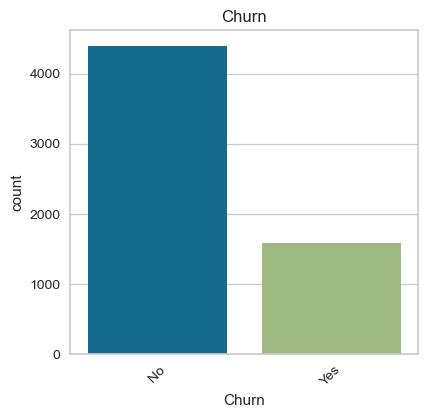

In [25]:
fig, ax = plt.subplots(sharex=False, sharey=False, figsize = (4, 4))
sns.countplot(data = df_churn, x = "Churn", ax = ax)
ax.tick_params(axis='x', rotation=45)
ax.set_title("Churn");

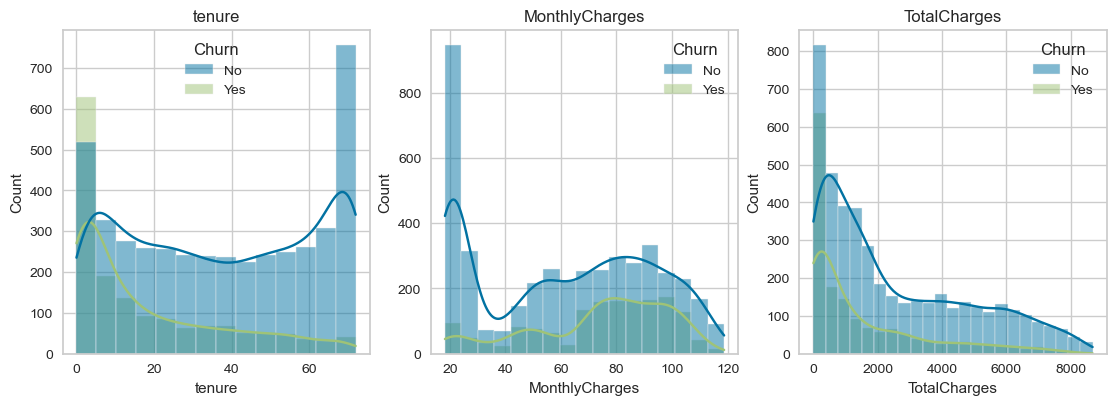

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize = (12, 4))
ax = ax.flatten()
for i, nc in enumerate(numerical_variables):
    sns.histplot(data = df_churn, x = nc, hue='Churn', kde = True, fill = True, ax = ax[i])
    ax[i].set_title(nc)

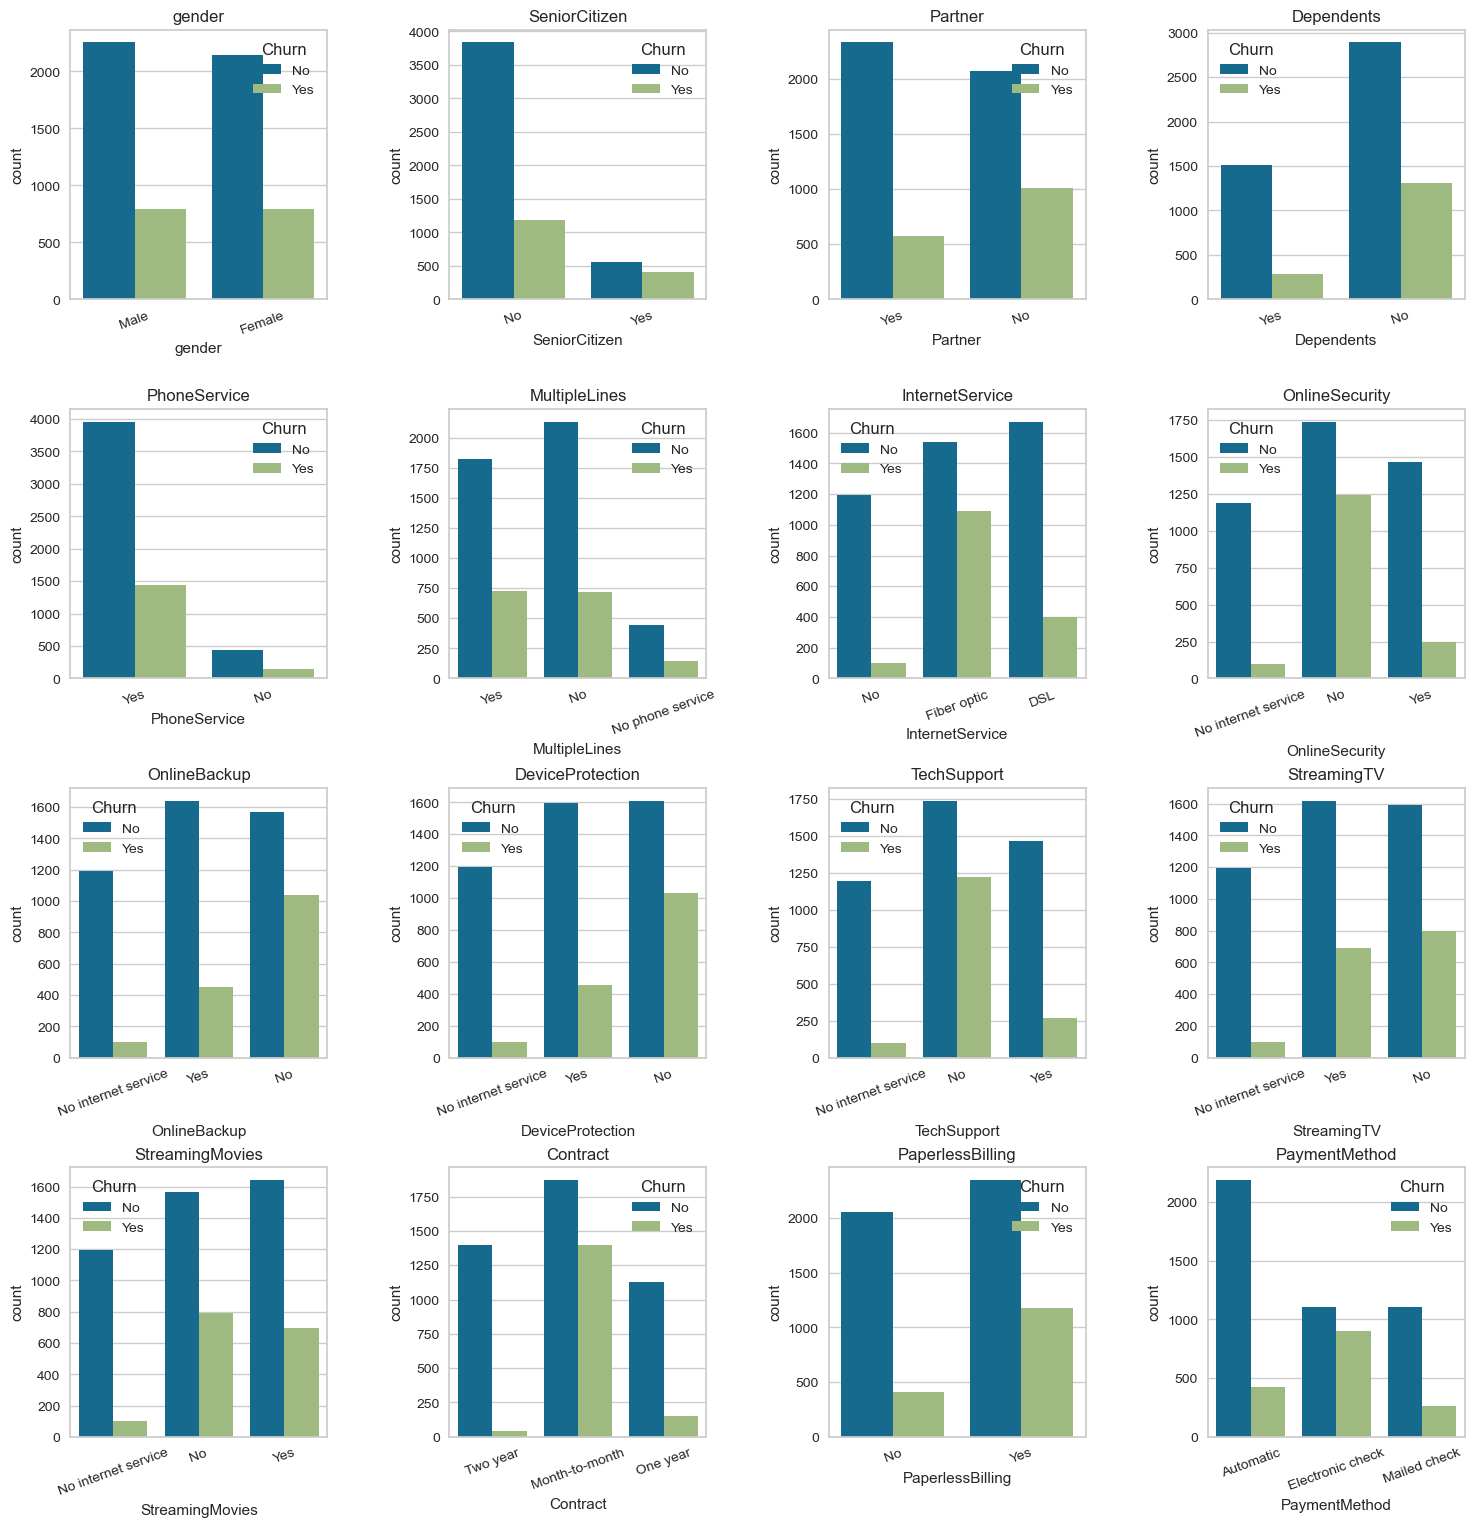

In [29]:
fig, ax = plt.subplots(nrows=4, ncols=4, sharex=False, sharey=False, figsize = (16, 16))
fig.tight_layout(pad = 5)
ax = ax.flatten()
for i, nc in enumerate(categorical_variables[:-1]):
    sns.countplot(data = df_churn, x = nc, hue='Churn', ax = ax[i])
    ax[i].tick_params(axis='x', rotation=20)
    ax[i].set_title(nc)

Storing the (minimal) clean dataset

In [31]:
# df_churn.to_csv("../data/clean/telecom_users_clean.csv", index = False)

## Reading new Data File

In [33]:
df_churn = pd.read_csv("../data/clean/telecom_users_clean.csv")